In [1]:
cd D:\\Saarbrucken\\EDA_Research\\vae-disentanglement\\disentanglement_lib_pl

D:\Saarbrucken\EDA_Research\vae-disentanglement\disentanglement_lib_pl


In [27]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple
from matplotlib import cm as mpl_colormaps
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import torch
import torchvision.utils as vutils
import torchvision.transforms.functional as T
from torch.utils.data import DataLoader
from torchvision import transforms

import models
from common.data_loader import DSpritesDataset, ThreeShapesDataset, ContinumDataset
#from common import notebook_utils
from common import utils
from common.notebook_utils import *
from common.utils import CenteredNorm
from gnncsvae_experiment import GNNCSVAEExperiment
from common.ops import reparametrize
# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})
np.set_printoptions(suppress=True,precision=4)

In [8]:
# these two will be used any time we load a saved checkppoint

PROJECT_ROOT = r"D:\Saarbrucken\EDA_Research\vae-disentanglement"
datapath = os.path.join(PROJECT_ROOT, "datasets")
os.environ['DISENTANGLEMENT_LIB_DATA'] = datapath

ModelParams = namedtuple('ModelParams', ["z_dim", "l_dim", "num_labels" , "in_channels", 
                                        "image_size", "batch_size", "w_recon", "w_kld", "w_sup_reg", "kl_warmup_epochs",
                                         "adjacency_matrix", "loss_terms", "use_loss_weights",
                                        "controlled_capacity_increase", "iterations_c", "max_capacity", "dset_name"
                                        ])

ExpParams = dict(
        in_channels=-1,
        image_size=64,
        LR=1e-4,
        weight_decay=0.0,       
        dataset=None,
        datapath=datapath,
        droplast=True,        
        batch_size=64,
        num_workers=0,
        pin_memory=False,
        seed=123,
        evaluation_metrics=None,
        visdom_on=False,
        save_dir=None,
        max_epochs=1,
        l_zero_reg=False
)



In [9]:
# load the learned model here

algo_name = "GNNBasedConceptStructuredVAE"
checkpoint_path = os.path.join(PROJECT_ROOT, "models", "pendulum200epoch1dim.ckpt")
z_dim = 1
channels = 3
l_dim = 4
num_nodes = 4
dataset = "pendulum"
current_device = torch.device("cuda:0")

# prep params
model_params = ModelParams(
        [z_dim], l_dim, 0, channels, 64, 64, 0.80, 0.15, 0.0, 0,
        os.path.join(PROJECT_ROOT, "adjacency_matrices", f"{dataset}.pkl"),
        [], False,
        False, 0, 0, "pendulum"
)

ExpParams['channels'] = channels

# load model
vae_model_class = getattr(models, algo_name)
vae_model = vae_model_class(model_params)

vae_experiment = GNNCSVAEExperiment.load_from_checkpoint(
            checkpoint_path,
            vae_model=vae_model, 
            params=ExpParams,
            dataset_params=None).to(current_device)

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 0., 1.]])
GNNBasedConceptStructuredVAE Model Initialized


In [10]:
# load data
dataset = get_configured_dataset(dataset)
sample_loader = DataLoader(dataset, batch_size=64, shuffle = False, drop_last=True)

In [11]:
len(sample_loader)

114

In [12]:
# Load the activations

mu_batches, label_batches = csvaegnn_get_latent_activations_with_labels_for_scatter(vae_model, sample_loader, 
                                                                                    current_device, batches = 110)

print(mu_batches.shape, label_batches.shape)

(7040, 4, 1) (7040, 4)


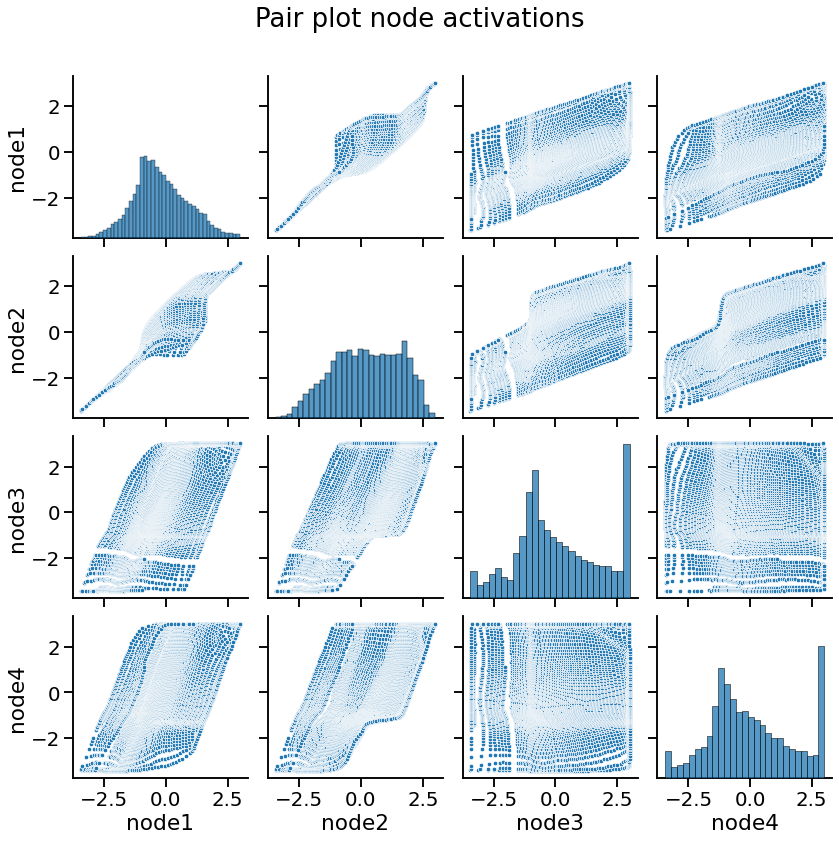

In [62]:
#fig, ax = plt.subplots()
#fig.set_size_inches(11.7, 8.4)
    
# suppress the feat_dim dimension, assuming it has only 1-dim

activations = mu_batches.squeeze(2)
activations_df = pd.DataFrame(activations, columns=["node1","node2","node3","node4"])
activations_df.head()
sns_plot = sns.pairplot(activations_df, markers=".", height=3.0)
sns_plot.fig.suptitle("Pair plot node activations")
sns_plot.fig.subplots_adjust(top=0.9)
#sns_plot.savefig("test.jpg")

<AxesSubplot:>

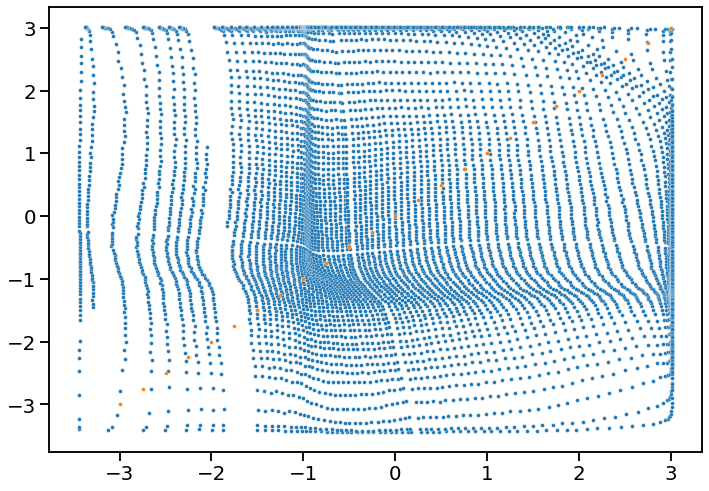

In [13]:
# traverse along a path
x = torch.arange(-3,3.1, 0.25)
y = 1.0 * x

xy = torch.stack([x,y]).to(current_device)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.2)

x_plot = mu_batches[:, 2, 0]
y_plot = mu_batches[:, 3, 0]

sns.scatterplot(   
    x=x_plot, 
    y=y_plot, 
    s=15, 
    ax=ax
)

traverse_plot = xy.cpu().numpy()
sns.scatterplot(   
    x=traverse_plot[0], 
    y=traverse_plot[1], 
    s=15, 
    ax=ax
)

tensor([-0.9091, -0.1750, -0.3019, -0.0776])


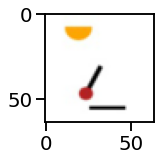

In [14]:
# get any one image
imgs, labels = next(sample_loader.__iter__())
print(labels[33])
anchor_image = imgs[33]
fig, ax = plt.subplots(figsize=(2,2))
ax.imshow(anchor_image.permute(1,2,0), cmap='gray')
anchor_image = anchor_image.unsqueeze(0).to(current_device)

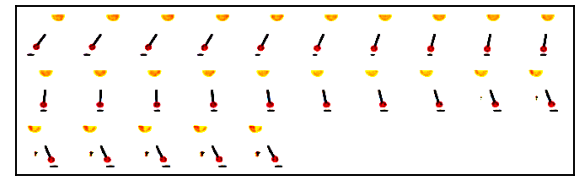

In [15]:
csvaegnn_show_traversal_images(vae_model, anchor_image, 3, 0.25, current_device=current_device,
                                    dim_to_explore=0, mode='relative',
                                    nodes_to_explore=[2,3], datapoints=xy.T, nrow=10, figsize=(10,10))

<AxesSubplot:>

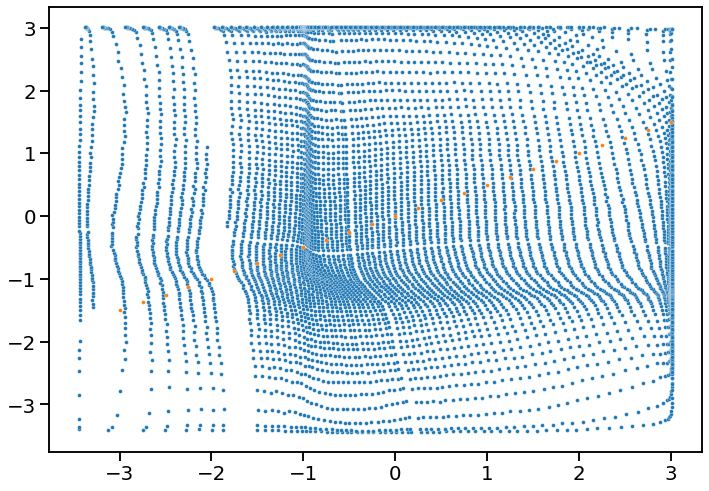

In [44]:
# traverse along a path
x = torch.arange(-3,3.1, 0.25)
y = 0.5 * x

xy = torch.stack([x,y]).to(current_device)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.2)

x_plot = mu_batches[:, 2, 0]
y_plot = mu_batches[:, 3, 0]

sns.scatterplot(   
    x=x_plot, 
    y=y_plot, 
    s=15, 
    ax=ax
)

traverse_plot = xy.cpu().numpy()
sns.scatterplot(   
    x=traverse_plot[0], 
    y=traverse_plot[1], 
    s=15, 
    ax=ax
)

In [ ]:
def intervene_upper_layers(vae_model, x, intervention_level, intervention_nodes, intervention_values):
    """
    Function assumes 1-d latent space for node features

    """
    
    gnn_levels = len(vae_model.encoder_gnn)
    assert intervention_level < gnn_levels, f"GNN depth has {gnn_levels} layers, can't intervene on {intervention_level} layer"
    mu, logvar = None, None
    samples = []
    
    with torch.no_grad():
        
        mse = vae_model.encoder_cnn(x)

        for intervention_value in intervention_values:
            z = mse.clone()
            for g, gnn_layer in enumerate(vae_model.encoder_gnn):
                #print(g)
                # compute activations at this GNN level
                z = gnn_layer(z)

                # if this is the intervention level we have to replace the computed 
                # value for nodes on which we're intervening to the given intervention_values
                if g == intervention_level:
                    if g == gnn_levels - 1:
                        mu, logvar = z
                        mu[:, intervention_nodes, 0] = intervention_value
                        z = mu, logvar
                    else:
                        z[:, intervention_nodes, 0] = intervention_value

            # intervention has propagated, now we can recon
            z_sample = reparametrize(*z)
            z_flattened = vae_model.flatten_node_features(z_sample)
            sample = vae_model.decode(z_flattened).data

            samples.append(sample)

    return samples

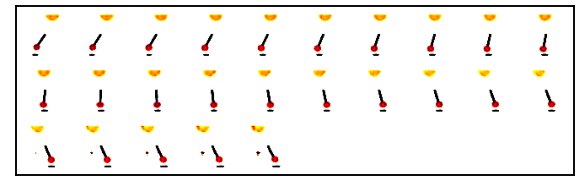

In [45]:
csvaegnn_show_traversal_images(vae_model, anchor_image, 3, 0.25, current_device=current_device,
                                    dim_to_explore=0, mode='relative',
                                    nodes_to_explore=[2,3], datapoints=xy.T, nrow=10, figsize=(10,10))

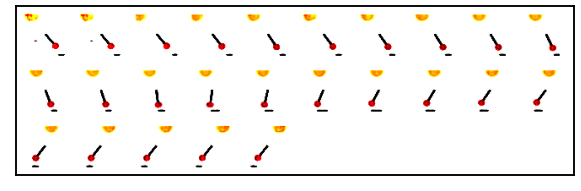

In [49]:
import torchvision
from common import notebook_utils

samples = intervene_upper_layers(vae_model, anchor_image, intervention_level=0, intervention_nodes=[2,3], intervention_values=xy.T)

traversed_images_stacked = torch.stack([t_img.squeeze(0) for t_img in samples], dim=0)
img_grid = torchvision.utils.make_grid(traversed_images_stacked, normalize=True, nrow=10, value_range=(0.0,1.0), pad_value=1.0)

notebook_utils.__show(img_grid, figsize=(10,10))


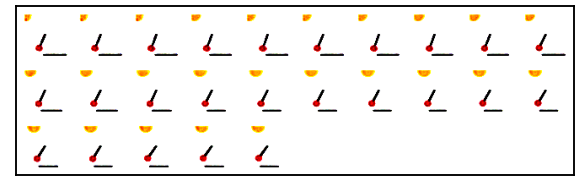

In [56]:
samples = intervene_upper_layers(vae_model, anchor_image, intervention_level=0, intervention_nodes=[0,1], intervention_values=xy.T)

traversed_images_stacked = torch.stack([t_img.squeeze(0) for t_img in samples], dim=0)
img_grid = torchvision.utils.make_grid(traversed_images_stacked, normalize=True, nrow=10, value_range=(0.0,1.0), pad_value=1.0)

notebook_utils.__show(img_grid, figsize=(10,10))

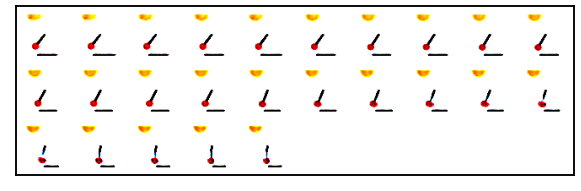

In [54]:
t = torch.arange(-3,3.1, 0.25).to(current_device)

samples = intervene_upper_layers(vae_model, anchor_image, intervention_level=1, 
                                 intervention_nodes=[1], intervention_values=t.T)

traversed_images_stacked = torch.stack([t_img.squeeze(0) for t_img in samples], dim=0)

img_grid = torchvision.utils.make_grid(traversed_images_stacked, normalize=True, nrow=10, value_range=(0.0,1.0), pad_value=1.0)

notebook_utils.__show(img_grid, figsize=(10,10))

# Perturbing individual nodes and seeing what factors they affect

In [ ]:
# node 1 -- pen angle

# Sun moves to left slightly. 
# Shadow length changes a bit. 
# Pendulum angle stays the same
# Shadow position stays the same

# (Sun, Shadow Len) change
# (Pendulum Angle, Shadow Pos) stays same

csvaegnn_show_traversal_images(vae_model, anchor_image, limit=3, interp_step=1/5, node_to_explore=0, 
                               dim_to_explore=0,nrow=10, figsize=(10, 10))

In [ ]:
# node 2 -- light position

# Pendulum angle changes - but not full rotation
# Shadow position also varies slightly
# Shadow length decreases a bit
# Sun stays the same

# (Pendulum Angle, Shadow Pos, Shadow Len) change
# (Sun,) stays same

csvaegnn_show_traversal_images(vae_model, anchor_image, limit=3, interp_step=1/5, node_to_explore=1, 
                               dim_to_explore=0,nrow=10, figsize=(10, 10))

In [ ]:
# node 3 -- shadow length

# Pendulum swings from left to right. 
# Shadow length changes
# Shadow position changes
# Sun stays the same. 

# (Pendulum Angle, Shadow Pos, Shadow Len) change
# (Sun,) stays same

csvaegnn_show_traversal_images(vae_model, anchor_image, limit=3, interp_step=1/5, node_to_explore=2, 
                               dim_to_explore=0,nrow=10, figsize=(10, 10))

In [ ]:
# node 4 -- shadow position

# Sun source moves from right to left. 
# Shadow length changes. 
# Shadow position changes
# Pendulum angle stays same

# (Sun, Shadow Pos, Shadow Len) change
# (Pendulum Angle,) stays same

csvaegnn_show_traversal_images(vae_model, anchor_image, limit=3, interp_step=1/5, node_to_explore=3, 
                               dim_to_explore=0,nrow=10, figsize=(10, 10))

In [ ]:
# what happens when we change node 3 and 4 at the same time ?


In [ ]:
# Aliasing of cause and effect -- right now it appears that as i perturb this node the pendulum angle changes and in response the 
# shadow length also changes.. But it could be my projecting my causal understanding onto the network.. Who's to say that 
# in actuality perturbing the node changes the shadow length and the network then draws the appropriate pendulum stem angle.
# How can we be sure of directionality in these kind of traversal demonstrations?

# To resolve this we need to identify the cause and effect node and then vary both one at a time
# only cause node should exhibit this behaviour 


# Checking the Prior Dist

In [ ]:
# plot epsilons on the same axis with hue by node idx

epsilons = vae_model._get_exogen_samples(current_device)

fig, ax = plt.subplots()
fig.set_size_inches(5.5, 4.1)
    
grid = sns.FacetGrid(data=tips, col='day', col_wrap=2)

for node_idx in range(vae_model.num_nodes):   
    sns.histplot(epsilons[:, node_idx, 0].cpu(), kde=True, ax=ax)
    #plt.title(f"Dist of $\epsilon$_{node_idx}")
    plt.show()
 

In [ ]:
# plot z's on the same axis with hue by node idx